Step 1: Brief description of the problem and data

The goal of this project is to build a GAN that generates 7,000 to 10,000 images in the style of Monet from scenary photos. The Monet folder images can be used to train the model.

**Structures** : \
The dataset contains four subdirectories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. Using TFRecords to decompress rather than loading jpg file directly is suggested, but the files in tfrec and jpg folders are the same.

**GAN**: \
Generative Adversarial Network (GAN) is a type of machine learning model that consists of two neural networks—a generator and a discriminator—which compete with each other. The generator creates fake data (like images), while the discriminator tries to distinguish between real and fake data. Through this competition, the generator learns to produce more realistic data. This project uses ***Cycle GAN*** (Cycle-Consistent Generative Adversarial Network), which consists of two generators and two discriminators. One generator transforms images from one domain to another, while the other transforms them back. The cycle consistency loss ensures that when an image is translated to another domain and back, it should return to its original form. It does not require paired example for transformation.

**Data Size and Dimensions** :
1. monet_jpg : 300 Monet paintings sized 256x256 in JPEG format
2. monet_tfrec: 300 Monet paintings sized 256x256 in TFRecord format
3. photo_jpg: 7028 photos sized 256x256 in JPEG format
4. photo_tfrec: 7028 photos sized 256x256 in TFRecord format

In [ ]:
from google.colab import drive
import zipfile
import os
drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/Colab Notebooks/cycle_gan/gan-getting-started.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("dataset")

# !pip install tensorflow
# !pip install tensorflow-addons==0.21.0


Step 2: Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data \
1. Check if there is any corrupted TFR files since we will use the TFR files to decompress.
2. Show the number of files in JPG folders.
3. Display one decompressed Monet jpeg image and one photo jpeg image.


Total TFRecord files checked: 5
Corrupted TFRecord files found: 0

Total TFRecord files checked: 20
Corrupted TFRecord files found: 0
Number of files in monet_jpg directory: 300
Number of files in photo_jpg directory: 7038


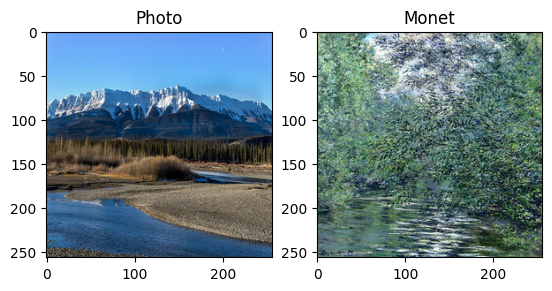

In [2]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

def check_corrupted_files(directory):
    corrupted_files = []
    total_files = 0
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            total_files += 1
            try:
                # Attempt to read the TFRecord file
                for _ in tf.data.TFRecordDataset(file_path).take(1):
                    pass  # Successfully read at least one record
            except Exception as e:
                corrupted_files.append(file_path)
                print(f"Corrupted TFRecord detected: {file_path} - {e}")

    print(f"\nTotal TFRecord files checked: {total_files}")
    print(f"Corrupted TFRecord files found: {len(corrupted_files)}")
    return corrupted_files

# Required image size from the project overview
IMAGE_SIZE = [256, 256]

#Tensor Flow optimization when mapping TRF datasets
AUTOTUNE = tf.data.experimental.AUTOTUNE

def decode_image(image):
    #Decode to JPEG, RGB
    image = tf.image.decode_jpeg(image, channels=3)

    # Turn image pixels to float32 and normalize to the range [-1, 1] instead of [0, 255]
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

# Decode files in TRF files
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

# Read TRF files
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

directory_path = "dataset/monet_tfrec"
corrupted_files = check_corrupted_files(directory_path)
directory_path = "dataset/photo_tfrec"
corrupted_files = check_corrupted_files(directory_path)

monet_jpg_dir = "dataset/monet_jpg"
monet_jpg_count = len([f for f in os.listdir(monet_jpg_dir) if f.endswith('.jpg')])
print(f"Number of files in monet_jpg directory: {monet_jpg_count}")

photo_jpg_dir = "dataset/photo_jpg"
photo_jpg_count = len([f for f in os.listdir(photo_jpg_dir) if f.endswith('.jpg')])
print(f"Number of files in photo_jpg directory: {photo_jpg_count}")


MONET_FILENAMES = tf.io.gfile.glob("dataset/monet_tfrec/*.tfrec")
PHOTO_FILENAMES = tf.io.gfile.glob("dataset/photo_tfrec/*.tfrec")


monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))



plt.subplot(121)
plt.title('Photo')
# Clip the image to match the range [-1, 1]
plt.imshow(example_photo[0]* 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0]* 0.5 + 0.5)




Step 3: Model Architecture

The project suggests to use the CycleGan model, comprising: \
1. Generators: Transforming photos to Monet-style images and vice versa \
2. Discriminators: Differentiating between the generated outputs and real images.

Although the primary objective is to generate photos in Monet's style, it's essential to train generators and discriminators for both directions. This bidirectional training enhances the model's performance by leveraging the loss from both transformations.

Here is the structure of the CycleGAN class:
1. ***build generator***: This is a bidrectional generator that \
 i. Uses the ***downsample*** method to extract key features from the input image. \
 ii. Applies ***residual_blocks*** to transform the image into a Monet-style while retaining essential original features. Currently, the transformation is hardcoded to iterated 6 times.\
 iii. Reconstructs the transformed image back to the original input dimensions with the help of ***upsample*** method, preparing it for subsequent processing steps.
2. ***build discriminator***: With similar steps, this method is more detailed in feature extraction with extra downsampling and outputs a probability score with sigmoid activation
3. ***train step***: This method uses gradient tape for backpropagation to improve the model. It includes the following steps: \
  i. Generating fake images based on the original input images. \
  ii. Discriminating whether the generated images are real or fake. \
  iii. Using ***generator_loss*** to measure how well the generated images deceive the discriminator. \
  iv. Using ***cycle_consistency_loss*** to measure how well the current model configuration can transform the generated images back to the original ones. \
  v. Calculating the total loss to assess how well the generators are creating deceptive images while retaining key features of the original images. \
  vi. Using ***discriminator_loss*** to evaluate how accurately the discriminator can distinguish between real and fake images. \
  vii. Calculating gradients from the above losses and applying the optimizer (default learning rate of 0.0002) to update the model and improve its performance.

  

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os

class CycleGAN:
    def __init__(self):
        self.generator_g = self.build_generator()  # Photo to Monet
        self.generator_f = self.build_generator()  # Monet to Photo

        self.discriminator_x = self.build_discriminator()  # Monet Discriminator
        self.discriminator_y = self.build_discriminator()  # Photo Discriminator

        self.generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5) # around 0.0002
        self.generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

        self.discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
        self.discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    @staticmethod
    def downsample(filters, size):
        return tf.keras.Sequential([
            layers.Conv2D(filters, size, strides=2, padding='same',
                          kernel_initializer=tf.random_normal_initializer(0., 0.02)),
            layers.BatchNormalization(),
            layers.LeakyReLU()
        ])

    @staticmethod
    def upsample(filters, size):
        return tf.keras.Sequential([
            layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                    kernel_initializer=tf.random_normal_initializer(0., 0.02)),
            layers.BatchNormalization(),
            layers.ReLU()
        ])

    @staticmethod
    def residual_block(filters):
        def block(x):
            y = layers.Conv2D(filters, (3, 3), padding='same',
                              kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)
            y = layers.ReLU()(y)
            y = layers.Conv2D(filters, (3, 3), padding='same',
                              kernel_initializer=tf.random_normal_initializer(0., 0.02))(y)
            return layers.Add()([x, y])
        return block

    def build_generator(self):
        inputs = layers.Input(shape=[256, 256, 3])

        x = self.downsample(64, 4)(inputs)
        x = self.downsample(128, 4)(x)

        for _ in range(6):
            x = self.residual_block(128)(x)

        x = self.upsample(64, 4)(x)
        outputs = layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh',
                                          kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)
        return tf.keras.Model(inputs, outputs)

    def build_discriminator(self):
        inputs = layers.Input(shape=[256, 256, 3])

        x = self.downsample(64, 4)(inputs)
        x = self.downsample(128, 4)(x)
        x = self.downsample(256, 4)(x)
        outputs = layers.Conv2D(1, 4, padding='same', activation='sigmoid',
                                kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)
        return tf.keras.Model(inputs, outputs)

    @staticmethod
    def cycle_consistency_loss(real_image, cycled_image):
        return tf.reduce_mean(tf.abs(real_image - cycled_image))


    @staticmethod
    def generator_loss(fake_output):
        return tf.reduce_mean(tf.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output))

    @staticmethod
    def discriminator_loss(real_output, fake_output):
        real_loss = tf.reduce_mean(tf.losses.binary_crossentropy(tf.ones_like(real_output), real_output))
        fake_loss = tf.reduce_mean(tf.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output))
        return (real_loss + fake_loss) * 0.5

    # Calculating loss on tensor between input and transformed output from fake images
    @staticmethod
    def identity_loss(real_image, same_image):
        return tf.reduce_mean(tf.abs(real_image - same_image))

    @tf.function
    def train_step(self, real_x, real_y):
        with tf.GradientTape(persistent=True) as tape:
            fake_y = self.generator_g(real_x, training=True)
            cycled_x = self.generator_f(fake_y, training=True)

            fake_x = self.generator_f(real_y, training=True)
            cycled_y = self.generator_g(fake_x, training=True)

            same_x = self.generator_f(real_x, training=True)
            same_y = self.generator_g(real_y, training=True)

            disc_real_x = self.discriminator_x(real_x, training=True)
            disc_real_y = self.discriminator_y(real_y, training=True)

            disc_fake_x = self.discriminator_x(fake_x, training=True)
            disc_fake_y = self.discriminator_y(fake_y, training=True)

            gen_g_loss = self.generator_loss(disc_fake_y)
            gen_f_loss = self.generator_loss(disc_fake_x)

            total_cycle_loss = self.cycle_consistency_loss(real_x, cycled_x) + self.cycle_consistency_loss(real_y, cycled_y)

            total_gen_g_loss = gen_g_loss + total_cycle_loss + self.identity_loss(real_y, same_y)
            total_gen_f_loss = gen_f_loss + total_cycle_loss + self.identity_loss(real_x, same_x)

            disc_x_loss = self.discriminator_loss(disc_real_x, disc_fake_x)
            disc_y_loss = self.discriminator_loss(disc_real_y, disc_fake_y)
        
        # 

        generator_g_gradients = tape.gradient(total_gen_g_loss, self.generator_g.trainable_variables)
        generator_f_gradients = tape.gradient(total_gen_f_loss, self.generator_f.trainable_variables)

        discriminator_x_gradients = tape.gradient(disc_x_loss, self.discriminator_x.trainable_variables)
        discriminator_y_gradients = tape.gradient(disc_y_loss, self.discriminator_y.trainable_variables)

        self.generator_g_optimizer.apply_gradients(zip(generator_g_gradients, self.generator_g.trainable_variables))
        self.generator_f_optimizer.apply_gradients(zip(generator_f_gradients, self.generator_f.trainable_variables))

        self.discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, self.discriminator_x.trainable_variables))
        self.discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, self.discriminator_y.trainable_variables))

        return {
            "gen_g_loss": total_gen_g_loss,
            "gen_f_loss": total_gen_f_loss,
            "disc_x_loss": disc_x_loss,
            "disc_y_loss": disc_y_loss,
        }

    def train(self, dataset, epochs, early_stop_patience=3, save_path="/content/drive/MyDrive/Colab Notebooks/cycle_gan"):
        os.makedirs(save_path, exist_ok=True)
        best_loss = float('inf')
        patience = 0

        for epoch in range(epochs):
            for image_x, image_y in dataset:
                losses = self.train_step(image_x, image_y)

            epoch_loss = losses["gen_g_loss"] + losses["gen_f_loss"]

            # Hardcode margin and early stop if model performance does not beat overall losses from previous epoch
            margin = 0.1
            if epoch_loss < best_loss - margin:
                best_loss = epoch_loss
                patience = 0
                self.save_models(epoch, save_path)
            else:
                patience += 1

            if patience >= early_stop_patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

            print(f"Epoch {epoch + 1}/{epochs}, Losses: {losses}")
    
    # Start training with a specific model       
    def load_models(self, epoch, save_path):
      self.generator_g = tf.keras.models.load_model(f"{save_path}/generator_to_monet_epoch_{epoch}.keras")
      self.generator_f = tf.keras.models.load_model(f"{save_path}/generator_to_photo_epoch_{epoch}.keras")
      self.discriminator_x = tf.keras.models.load_model(f"{save_path}/discriminator_dis_monet_epoch_{epoch}.keras")
      self.discriminator_y = tf.keras.models.load_model(f"{save_path}/discriminator_dis_photo_epoch_{epoch}.keras")

    # Save model on permanent volume
    def save_models(self, epoch, save_path):
        self.generator_g.save(f"{save_path}/generator_to_monet_epoch_{epoch + 1}.keras")
        self.generator_f.save(f"{save_path}/generator_to_photo_epoch_{epoch + 1}.keras")
        self.discriminator_x.save(f"{save_path}/discriminator_dis_monet_epoch_{epoch + 1}.keras")
        self.discriminator_y.save(f"{save_path}/discriminator_dis_photo_epoch_{epoch + 1}.keras")

cyclegan = CycleGAN()
cyclegan.load_models(epoch=4, save_path="/content/drive/MyDrive/Colab Notebooks/cycle_gan")
cyclegan.train(tf.data.Dataset.zip((photo_ds, monet_ds)), epochs=20)


Epoch 1/20, Losses: {'gen_g_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.3614314>, 'gen_f_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.6634429>, 'disc_x_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.6979352>, 'disc_y_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.6981921>}
Epoch 2/20, Losses: {'gen_g_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.3214117>, 'gen_f_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.6799997>, 'disc_x_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.6960631>, 'disc_y_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.7029247>}
Epoch 3/20, Losses: {'gen_g_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.2645413>, 'gen_f_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.5408273>, 'disc_x_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.6885421>, 'disc_y_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.69266653>}
Epoch 4/20, Losses: {'gen_g_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.269306>, 'gen_f_loss':

Step 4: Results and Analysis
1. The initial test run halted at Epoch 4. The output losses are shown in the chart below. A chart to compare the losses is shown below the code block.

```
    Epoch 1/25, Losses: {'gen_g_loss': <tf.Tensor: shape=(), dtype=float32, numpy=15162284>, 'gen_f_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.7460132>, 'disc_x_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.6958945>, 'disc_y_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.704603>}

    Epoch 2/25, Losses: {'gen_g_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.5002426>, 'gen_f_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.6961838>, 'disc_x_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.70288455>, 'disc_y_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.7046006>}

    Epoch 3/25, Losses: {'gen_g_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.4659293>, 'gen_f_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.704432>, 'disc_x_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.6969029>, 'disc_y_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.71241206>}

    Epoch 4/25, Losses: {'gen_g_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.4691447>, 'gen_f_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.6754346>, 'disc_x_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.7023946>, 'disc_y_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.6893697>
```

2. After resuming training from the models saved at Epoch 4, the iteration had an early stop at Epoch 6, and the model wasn't updated beyond Epoch 3. This indicates that Epoch 3 achieved the best performance in the second attempt. The corresponding chart is provided below.

3. When using the generator from Epoch 3 in the second attempt to create Monet-style images resulted in paintings with softer contrast, though some still resembled real photos.

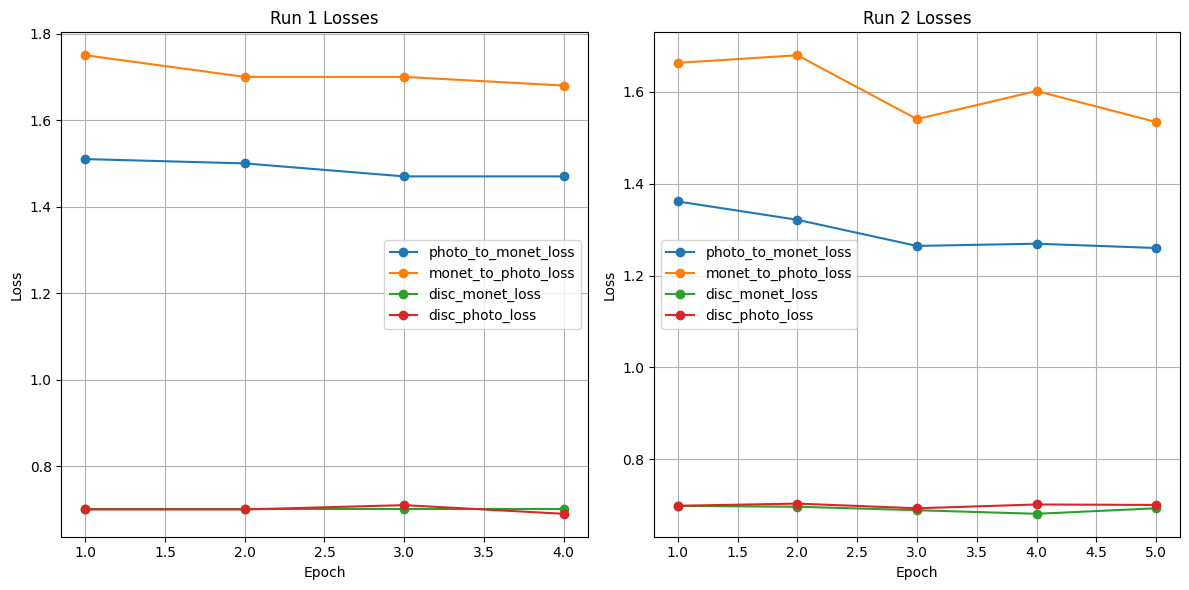

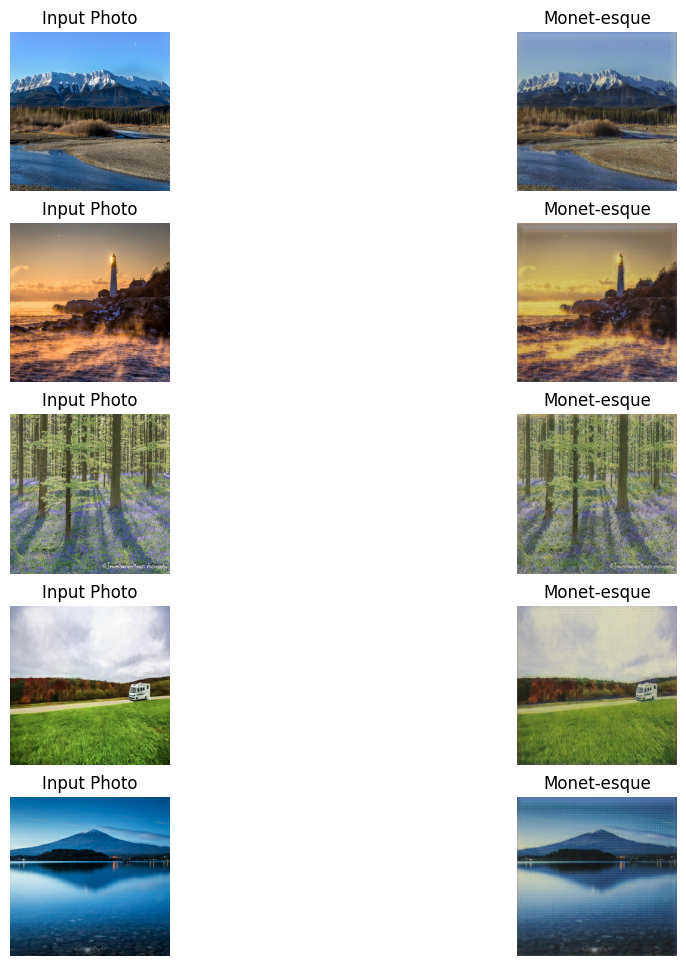

In [18]:
run_1_g_G_loss = [1.51, 1.50, 1.47, 1.47]
run_1_g_f_loss = [1.75, 1.70, 1.70, 1.68]
run_1_d_X_loss = [0.70, 0.70, 0.70, 0.70]
run_1_d_Y_loss = [0.70, 0.70, 0.71, 0.69]

run_2_g_G_loss = [1.3614, 1.3214, 1.2645, 1.2693, 1.2600]
run_2_g_f_loss = [1.6634, 1.6800, 1.5408, 1.6021, 1.5345]
run_2_d_X_loss = [0.6979, 0.6961, 0.6885, 0.6807, 0.6927]
run_2_d_Y_loss = [0.6982, 0.7029, 0.6927, 0.7010, 0.7000]

epochs_run_1 = range(1, len(run_1_g_G_loss) + 1)
epochs_run_2 = range(1, len(run_2_g_G_loss) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_run_1, run_1_g_G_loss, label='photo_to_monet_loss', marker='o')
plt.plot(epochs_run_1, run_1_g_f_loss, label='monet_to_photo_loss', marker='o')
plt.plot(epochs_run_1, run_1_d_X_loss, label='disc_monet_loss', marker='o')
plt.plot(epochs_run_1, run_1_d_Y_loss, label='disc_photo_loss', marker='o')
plt.title('Run 1 Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_run_2, run_2_g_G_loss, label='photo_to_monet_loss', marker='o')
plt.plot(epochs_run_2, run_2_g_f_loss, label='monet_to_photo_loss', marker='o')
plt.plot(epochs_run_2, run_2_d_X_loss, label='disc_monet_loss', marker='o')
plt.plot(epochs_run_2, run_2_d_Y_loss, label='disc_photo_loss', marker='o')
plt.title('Run 2 Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

monet_generator = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/cycle_gan/generator_to_monet_epoch_3.keras")
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [17]:
import PIL

i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save(f"/content/drive/MyDrive/Colab Notebooks/cycle_gan/output/{i}.jpg")
    i += 1



'/content/drive/MyDrive/Colab Notebooks/cycle_gan/output.zip'

Step 5: Conclusion \
To improve the accuracy, we can consider
1. Using Instance Normalization: Batch Normalization depends on the statistics of the entire batch, making it less effective for small batch sizes. Instance Normalization normalizes each individual instance independently. Since we have a small batch (300 paintings) and we do not define the number of batch size, the batch algorithm might be applied on each input, which is not the best approach. Using Instance Normalization perhaps will better keep textures and features in Monet-style paintings and apply them on photos.

2. Fine-Tuning parameters: Increasing the number of filters allows the network to capture more complex patterns, while fine-tuning iteration counts can ensure sufficient training. Adjusting the value of learning rates in optimizer, the number of filters and iteration times in downsample, upsample, and train step method perhaps can catch more fine-grained features.

3. Fine-Tuning the Activation Function: We followed the tutorial and used LeakyReLU, which avoids dead neurons by allowing a small gradient to pass through for negative values. We can think of using ReLU or PReLU(parameterized ReLU) because they might offer better flexibility and expressiveness. 

4. Adjusting Kernel initializer: The kernel initializer affects how the weights of the network are initialized, which can impact convergence and model performance. He initialization is optimized for ReLU-based activations, while Xavier initialization balances weight distribution for both positive and negative activations. We can experiment both in addition to random_normal_initializer.

5. Adding additional Layers: We can add Dropout layers or/and Residual Connections. Dropout layers can prevent overfitting, especially in cases where we might have limited data (300 paintings). Residual Connections can enhance gradient flow and enable deeper networks without vanishing gradients.

6. Adjusting the margin for training: Currently we save models based on the best performance with all losses, we can focus on the loss on the Monet-photo generator. By focusing the loss function on generating the best Monet-style images, rather than optimizing all losses equally, the model can better learn the Monet-specific features critical for style transfer.

References: \
https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial
